# Question 1

In [11]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

seed = 10465815
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

stocks = ['AMZN', 'TSLA']
source = 'stooq'
data = pdr.DataReader(stocks, source, '2020-01-01', '2022-01-01')['Close']
returns = (np.log(data) - np.log(data.shift(1))).dropna()

df = pd.DataFrame()
df['AMZN Lag 0'] = returns['AMZN'].shift(-2)[:-2]
df['AMZN Lag 1'] = returns['AMZN'].shift(-1)[:-2]
df['AMZN Lag 2'] = returns['AMZN'].shift(-1)
df['TSLA Lag 1'] = returns['TSLA'].shift(-2)[:-2]
df['TSLA Lag 2'] = returns['TSLA'].shift(-1)[:-2]
direction = (df['AMZN Lag 0'] > 0)+0
df['direction'] = direction
df = df[['AMZN Lag 0', 'direction', 'AMZN Lag 1', 'AMZN Lag 2', 'TSLA Lag 1', 'TSLA Lag 2']]
df = df.reset_index(drop=True)
df.head(6)

,AMZN Lag 0,direction,AMZN Lag 1,AMZN Lag 2,TSLA Lag 1,TSLA Lag 2
0,0.008592,1,0.003297,0.003297,0.002097,0.014699
1,-0.005824,0,0.008592,0.008592,0.005015,0.002097
2,0.008206,1,-0.005824,-0.005824,-0.024935,0.005015
3,-0.000181,0,0.008206,0.008206,-0.056021,-0.024935
4,-0.003632,0,-0.000181,-0.000181,-0.072272,-0.056021
5,-0.019782,0,-0.003632,-0.003632,-0.041986,-0.072272


## Question 1.5
Consider the same classification problem as in Question 1.2 but with a neural network of your own design with at least 1 hidden layer and at least 3 hidden nodes.
Use the same train/test split as in Question 1.2.
Evaluate the performance of this model with the test accuracy and confusion matrix.

In [15]:
from sklearn.metrics import confusion_matrix
from tensorflow import keras

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


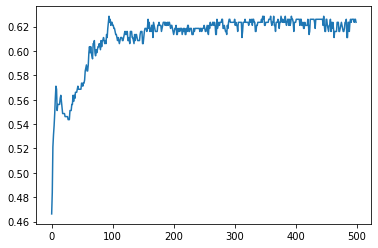

4/4 [==============================] - 0s 3ms/step
0.5092637976668954
[[40 15]
 [21 25]]
0.6234413981437683


In [19]:
n = len(df)
train = np.random.choice(int(n), size=int(n*0.8), replace=False)
df_train = df.loc[train]
X_train = df_train[['AMZN Lag 1', 'AMZN Lag 2', 'TSLA Lag 1', 'TSLA Lag 2']].to_numpy()
y_train = df_train[['direction']].to_numpy()

test = list(set(df.index.values) - set(df_train.index.values))
df_test = df.loc[test]
X_test = df_test[['AMZN Lag 1', 'AMZN Lag 2', 'TSLA Lag 1', 'TSLA Lag 2']].to_numpy()
y_test = df_test [['direction']].to_numpy()

NN = keras.Sequential()
NN.add(keras.layers.Dense(4, input_dim=4, activation = 'relu'))
NN.add(keras.layers.Dense(1, activation = 'sigmoid'))

NN.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics = ['accuracy'])
NN.summary()

losses = NN.fit(X_train, y_train, epochs = 500, verbose = 0)
plt.plot(losses.history['accuracy'])
plt.show()

NN_prob = NN.predict(X_test)
NN_pred = (NN_prob > 0.5)+0

print(np.mean(NN_pred.T == y_test))
print(confusion_matrix(y_pred = NN_pred, y_true=y_test))
print(losses.history['accuracy'][-1])

# Question 3

In [21]:
df_r = np.vstack((df['AMZN Lag 0'], df['AMZN Lag 1'], df['AMZN Lag 2'], df['TSLA Lag 1'], df['TSLA Lag 2'])).T
amzn = df_r[:, 0]
df_r1 = np.vstack((df['direction'], df['AMZN Lag 1'], df['AMZN Lag 2'], df['TSLA Lag 1'], df['TSLA Lag 2'])).T
direction = df_r1[:, 0]
print(np.quantile(amzn[train], [1/5, 2/5, 3/5, 4/5]))
direction[:] = 4

nums = [4/5, 3/5, 2/5, 1/5]
for i in range(len(nums)):
  direction[amzn > np.quantile(amzn[train], nums[i])] = i

direction_ohe = keras.utils.to_categorical(direction,num_classes=5)
y_test = np.delete(direction,train)

[-0.01428268 -0.00543977  0.00209512  0.01223078]


## Question 3.5
Consider the same classification problem as in Question 3.2 but with a neural network of your own design with at least 1 hidden layer and at least 3 hidden nodes.
Use the same train/test split as in Question 1.2.
Evaluate the performance of this model with the test accuracy and confusion matrix.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 4)                 20        
                                                                 
 dense_9 (Dense)             (None, 5)                 25        
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________


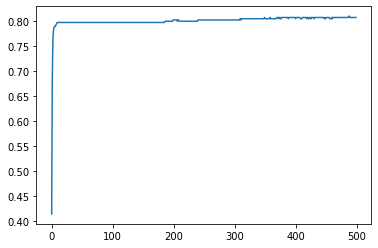

4/4 [==============================] - 0s 3ms/step
0.801980198019802
[[79  1]
 [19  2]]
0.8079800605773926


In [23]:
NN = keras.Sequential()
NN.add(keras.layers.Dense(4, input_dim=4, activation = 'relu'))
NN.add(keras.layers.Dense(5, activation='softmax'))

NN.compile(optimizer=keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics=['accuracy'])
NN.summary()

losses = NN.fit(X_train, direction_ohe[train, :], epochs = 500, verbose = 0)
plt.plot(losses.history['accuracy'])
plt.show()

NN_prob = NN.predict(X_test)
NN_pred = np.argmax(NN_prob, axis = 1)

print(np.mean(NN_pred.T == y_test))
print(confusion_matrix(y_pred = NN_pred, y_true=y_test))
print(losses.history['accuracy'][-1])

In [27]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('A4.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] WARNING | pattern '$notebookpath$file_name' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
 

'File Download Unsuccessful. Saved in Google Drive'